# Analysis of DeepPath Experiments
This notebook documents our analysis of performance results from various experiments ran on DeepPath models

## Setup

In [1]:
# Packages/Helper Function Import
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import deeppath_parsers as dp
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Directory Constants
# output_dir = Path("/data/jeremybk/failure_modes/work/output/")
# int_dir = Path("/data/jeremybk/failure_modes/work/intermediate")
output_dir = Path("/data/ncwang/histopath_failure_modes/work/output/")
int_dir = Path("/data/ncwang/histopath_failure_modes/work/intermediate")

In [3]:
# Helper function for loading many studies
def load_studies(studies,labels):
    # Parse slide probs
    slide_probs = pd.concat({
        study.stem:pd.DataFrame(dp.parse_slide_probs(study / "auc" / "out2_perSlideStats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    slide_probs["group"] = slide_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    slide_probs["group"].fillna("Control",inplace=True)
    slide_probs["study"] = pd.Categorical(slide_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    slide_probs.sort_values(["study","class"],inplace=True)
    slide_probs["study"] = slide_probs["study"].astype(str)
    # Parse tile probs
    tile_probs =  pd.concat({
        study.stem:pd.DataFrame(dp.parse_tile_probs(study / "out_filename_Stats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    tile_probs["group"] = tile_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    tile_probs["group"].fillna("Control",inplace=True)
    tile_probs["study"] = pd.Categorical(tile_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    tile_probs.sort_values(["study","class"],inplace=True)
    tile_probs["study"] = tile_probs["study"].astype(str)
    tile_probs.drop_duplicates(inplace=True)
    #Parse AUCs
    auc = pd.concat({
        study.stem:pd.DataFrame(dp.parse_auc_file(study / "auc_summary.txt"))
        for study in studies
    },names=["study"]).reset_index()
    auc["group"] = auc["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    auc["group"].fillna("Control",inplace=True)
    auc["study"] =pd.Categorical(auc["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    auc.sort_values(["study","class"],inplace=True)
    auc["study"] = auc["study"].astype(str)
    auc["ci_upper"] = auc["ci_upper"] - auc["auc"]
    auc["ci_lower"] = auc["auc"] - auc["ci_lower"]
    slide_auc = auc[auc.type=="slide"]
    tile_auc = auc[auc.type=="tile"]
    return slide_probs.drop_duplicates(),tile_probs,slide_auc,tile_auc
# Helper function for plotting with error bars
# Adapted from : https://stackoverflow.com/questions/45875143/seaborn-making-barplot-by-group-with-asymmetrical-custom-error-bars
def auc_error_bar_plot(x,y,hue,lb,ub,label_order,**kwargs):
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=hue, values=lb)
    errHi = data.pivot(index=x, columns=hue, values=ub)
    err = []
    for col in errLo:
        err.append([errLo[col].values, errHi[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=hue, values=y)
    p = p.reindex(label_order).dropna(axis=0)
    fig = p.plot(kind='bar',yerr=err,ax=plt.gca(), **kwargs)
    return fig

In [4]:
# Phase 1 Study Labels
phase1_labels = {
    "exp_bubbles_20": "B 20%",
    "exp_bubbles_100": "B 100%",
    "exp_fold_20": "F 20%",
    "exp_fold_100": "F 100%",
    "exp_illumination_10": "I 10%",
    "exp_illumination_50": "I 50%",
    "exp_illumination_100": "I 100%",
    "exp_marker_50": "M 50%",
    "exp_marker_90": "M 90%",
    "exp_marker_100": "M 100%",
    "exp_sectioning_15": "Se 15%",
    "exp_sectioning_30" : "Se 30%",
    "exp_sectioning_100" : "Se 100%",
    "exp_stain_10": "St 10%",
    "exp_stain_30": "St 30%",
    "exp_stain_100": "St 100%",
    "exp_tear_15": "T 15%",
    "exp_tear_100": "T 100%",
    "all": "Control"
}

phase1_studies = list(output_dir.glob("exp_*_*")) + [output_dir / "all"]
phase1_slide_probs, phase1_tile_probs, phase1_slide_auc, phase1_tile_auc = load_studies(phase1_studies,phase1_labels)

# Duplicate Removal

In [5]:
# cleaning up some errored runs
phase1_tile_auc = phase1_tile_auc.drop_duplicates(keep='last',subset=('group','study','class'))
phase1_slide_auc = phase1_slide_auc.drop_duplicates(keep='last',subset=('group','study','class'))

## True probability plots

Text(0.5, 0.98, 'Slide Average True Probabilities')

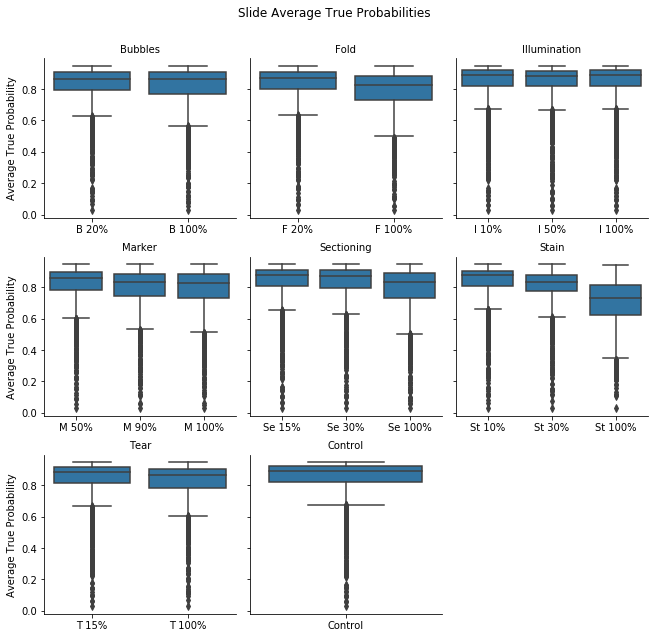

In [6]:
# Average True Prob Overall
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob")
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Slide Average True Probabilities")

Text(0.5, 0.98, 'Slide Average True Probabilities (By Class)')

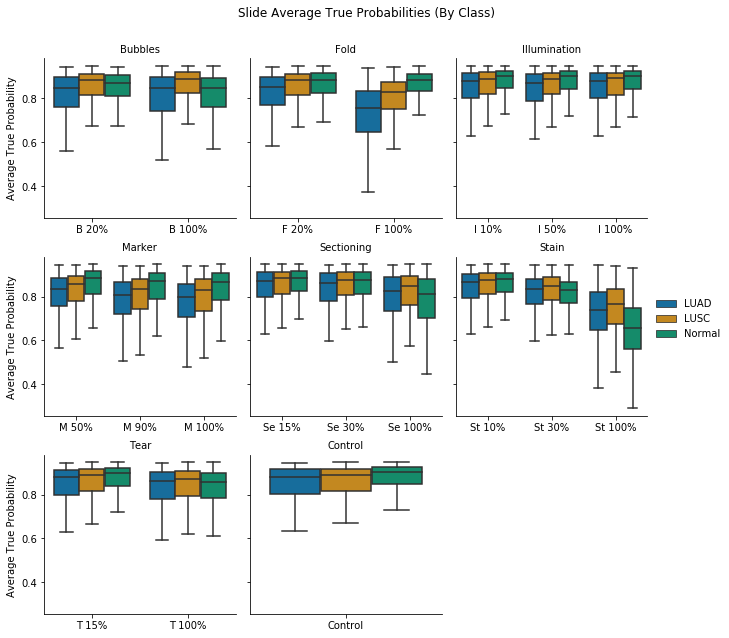

In [7]:
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob",hue="class",palette="colorblind",showfliers=False)
g.add_legend()

g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Slide Average True Probabilities (By Class)")

Text(0.5, 0.98, 'Slide Average True Probabilities (By Class)')

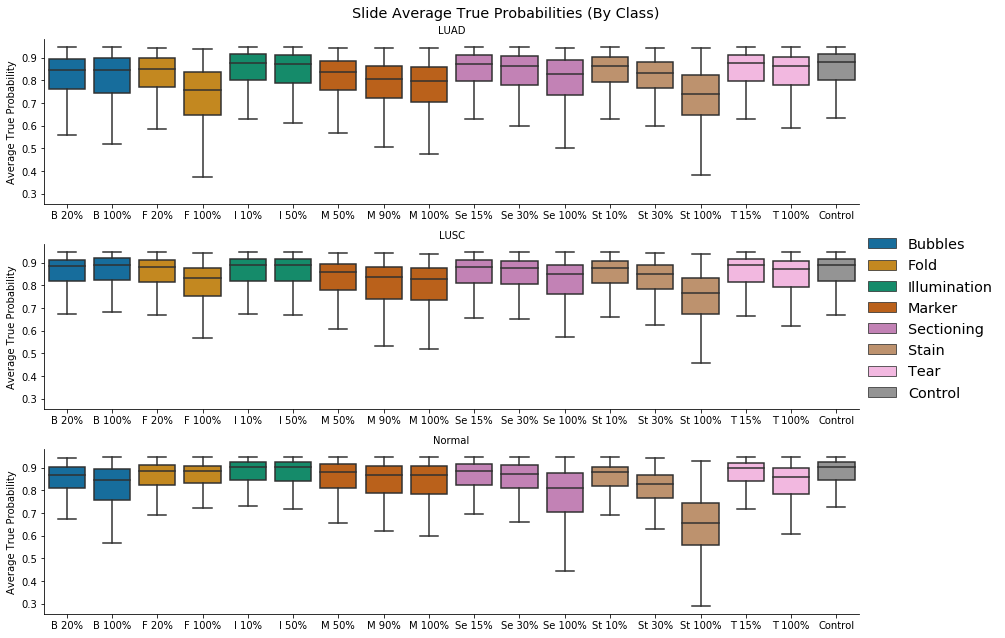

In [8]:
g = sns.FacetGrid(data=phase1_slide_probs.where(phase1_slide_probs.study != "I 100%"),
                  col="class",sharex=False,col_wrap=1,height=3,aspect = 4)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob",hue="group",palette="colorblind",
                showfliers=False, dodge=False)
g.add_legend(fontsize='x-large')
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.93)
plt.suptitle("Slide Average True Probabilities (By Class)",fontsize='x-large')

Text(0.5, 0.98, 'Tile True Probabilities (By Class)')

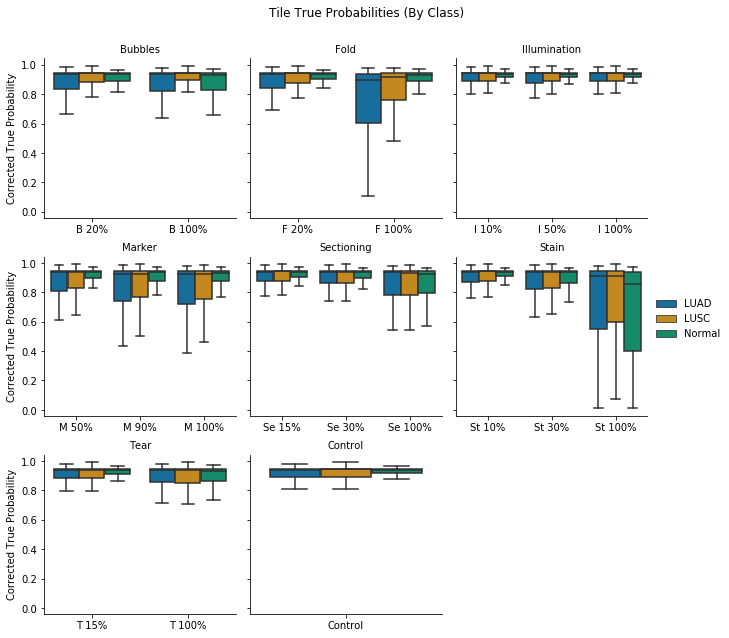

In [9]:
g = sns.FacetGrid(data=phase1_tile_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",showfliers=False)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Tile True Probabilities (By Class)")

Text(0.5, 0.98, 'Tile True Probabilities (By Class)')

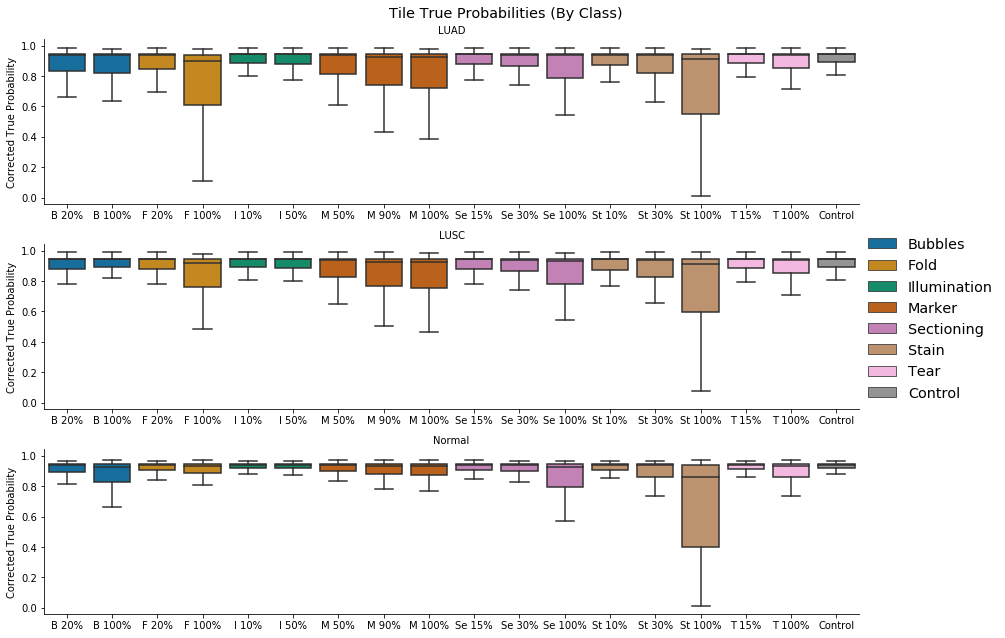

In [10]:
g = sns.FacetGrid(data=phase1_tile_probs.where(phase1_tile_probs.study != "I 100%"),
                  col="class",sharex=False,col_wrap=1,height=3,aspect = 4)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="group",palette="colorblind",
                showfliers=False, dodge=False)
g.add_legend(fontsize='x-large')
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.93)
plt.suptitle("Tile True Probabilities (By Class)",fontsize='x-large')

## AUC Plots

class     LUAD    LUSC  Normal
study                         
B 20%   0.9631  0.9645  0.9940
B 100%  0.9606  0.9614  0.9914
class     LUAD    LUSC  Normal
study                         
F 20%   0.9651  0.9668  0.9943
F 100%  0.9502  0.9542  0.9909
class     LUAD    LUSC  Normal
study                         
I 10%   0.9693  0.9708  0.9956
I 50%   0.9680  0.9698  0.9952
I 100%  0.9692  0.9707  0.9955
class     LUAD    LUSC  Normal
study                         
M 50%   0.9609  0.9635  0.9945
M 90%   0.9527  0.9563  0.9934
M 100%  0.9500  0.9542  0.9931
class      LUAD    LUSC  Normal
study                          
Se 15%   0.9670  0.9684  0.9947
Se 30%   0.9646  0.9662  0.9943
Se 100%  0.9505  0.9525  0.9903
class      LUAD    LUSC  Normal
study                          
St 10%   0.9640  0.9662  0.9933
St 30%   0.9511  0.9549  0.9877
St 100%  0.8900  0.9008  0.9604
class     LUAD    LUSC  Normal
study                         
T 15%   0.9687  0.9701  0.9954
T 100%  0.9634  0.9642  0.994

Text(0.5, 0.98, 'AUC By Tile')

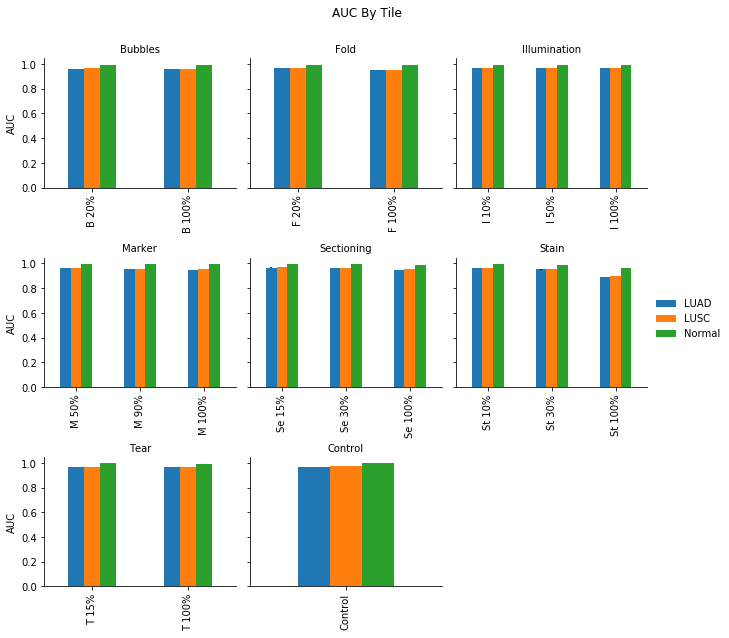

In [11]:
def auc_error_bar_plot(x,y,hue,lb,ub,label_order,**kwargs):
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=hue, values=lb)
    errHi = data.pivot(index=x, columns=hue, values=ub)
    err = []
    for col in errLo:
        err.append([errLo[col].values, errHi[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=hue, values=y)
    p = p.reindex(label_order).dropna(axis=0)
    print(p)
    fig = p.plot(kind='bar',yerr=err,ax=plt.gca(), **kwargs)
    return fig

g = sns.FacetGrid(phase1_tile_auc, col="group",sharex=False,col_wrap=3) 
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",
                label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("AUC By Tile")

Text(0.5, 0.98, 'AUROC per Tile (By Class)')

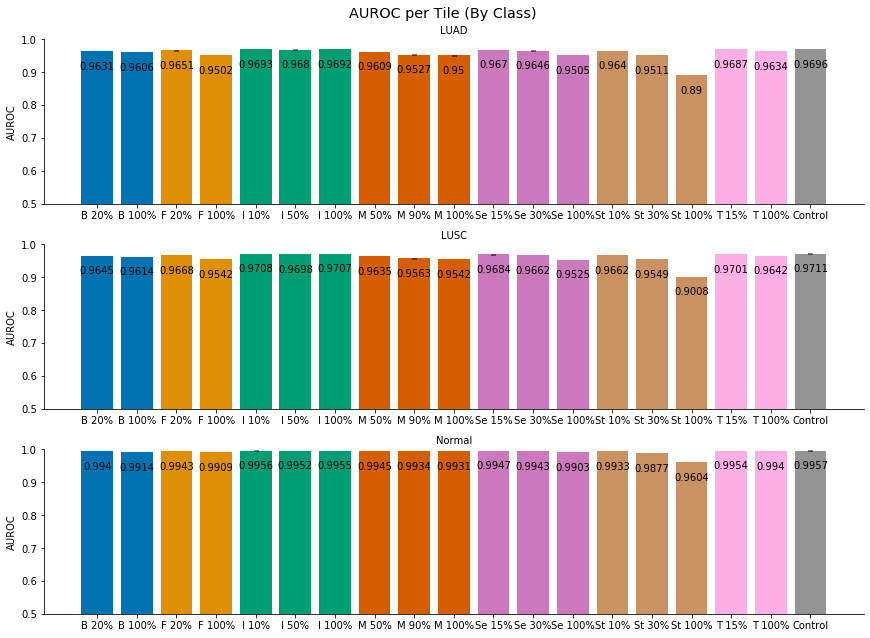

In [12]:
from matplotlib import colors as collib
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def auc_error_bar_plot2(x,y,hue,lb,ub,label_order,piv=None,palette=None,**kwargs):
    if piv == None:
        piv = hue
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=piv, values=lb)
    errHi = data.pivot(index=x, columns=piv, values=ub)
#     print(errLo)
    err = []
    for col in errLo.index:
        err.append([errLo.loc[col].values, errHi.loc[col].values])
#     err = np.transpose(np.abs(err), (2, 1, 0))
    err = np.abs(err)
    err = np.transpose(np.squeeze(err),(1,0))
    
    p = data.pivot(index=piv, columns=x, values=y)
    order = [l for l in label_order if l in p.columns]
#     print(order,label_order)
    p = p.reindex(columns =order).dropna(axis=0)
#     print(p.columns)
    groupNames = phase1_tile_auc.pivot(index=x, columns=piv, values="group")
    color_pal=sns.color_palette(palette)
#     colors = []
#     for col in groupNames:
    grpNames = groupNames.loc[p.columns].iloc[:,0].values
    [grpNos,grpUNames] = pd.factorize(groupNames.loc[p.columns].iloc[:,0].values)
    grpCols = []
    for idx in range(len(grpNos)):
#         print(grpNos)
        hexCol = collib.to_hex(color_pal[grpNos[idx]])
        grpCols.append(hexCol)
#         colors.append(grpCols)
    
    
#     p = p.reindex(["LUAD","LUSC","Normal"]).dropna(axis=0)
#     print( p)
#     fig = p.plot(kind="bar",yerr=err,ax=plt.gca(),**kwargs)
#     print(p.values.flatten(),err.shape)
#     print(p.columns)
#     for x,y,c,lb,eb in zip(p.columns,p.values.flatten(),grpCols,grpNames,err):
#         fig = plt.bar(x, y, color=c,label=lb)
#         print(x)
#         autolabel(fig)
    fig = plt.bar(p.columns,p.values.flatten(),yerr=err, label = grpNames,color = grpCols,error_kw = {"elinewidth": 5,'capthick':5})
    plt.ylim(.5,1)
    autolabel(fig)
#     fig = p.plot(kind="bar",yerr=err,ax=plt.gca(),color = grpCols,width = .9)
    
    return plt.gcf()

g = sns.FacetGrid(data=phase1_tile_auc,col="class",sharex=False,sharey=True,
                  col_wrap=1,height=3,aspect = 4)
g.map_dataframe(auc_error_bar_plot2,x="study",y="auc",hue="group", lb="ci_lower", ub="ci_upper",
                label_order=phase1_labels.values(),piv="class",palette="colorblind",dodge=False)
# g.map_dataframe(sns.barplot,x="study",y="auc",hue="group",
#                 palette="colorblind",dodge=False)
# g.add_legend(fontsize='x-large')
# temp = pd.unique(phase1_tile_auc["group"])
# temp = ['Bubbles','Fold','Illumination','Marker','Sectioning','Stain','Tear', 'Control']
# print(temp)
# plt.gca().legend(labels = temp)
# g.set(ylim=(.9, 1))

g.set_titles("{col_name}")
g.set_ylabels("AUROC")
plt.subplots_adjust(top=0.93)
plt.suptitle("AUROC per Tile (By Class)",fontsize='x-large')

In [13]:
errLo = phase1_tile_auc.pivot(index="study", columns="class", values="ci_lower")
errHi = phase1_tile_auc.pivot(index="study", columns="class", values="ci_upper")
groupNames = phase1_tile_auc.pivot(index="study", columns="class", values="group")
# print(errLo)
# print(errLo.index)
err = []
for row in errLo.index:
    err.append([errLo.loc[row].values, errHi.loc[row].values])
err = np.abs(err)
color_pal=sns.color_palette("colorblind")
colors = []

for col in groupNames:
    [grpNos,grpUNames] = pd.factorize(groupNames[col].values)
    grpCols = []
    for idx in range(len(grpNos)):
#         print(grpNos)
        grpCols.append(color_pal[grpNos[idx]])
    colors.append(grpCols)
print(grpCols)
print(err.shape)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.8, 0.47058823529411764, 0.7372549019607844), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921

In [14]:
groupNames = phase1_tile_auc.pivot(index="study", columns="class", values="group")


class     LUAD    LUSC  Normal
study                         
B 20%   0.9951  0.9943  0.9987
B 100%  0.9939  0.9926  0.9984
class     LUAD    LUSC  Normal
study                         
F 20%   0.9952  0.9940  0.9988
F 100%  0.9935  0.9907  0.9980
class     LUAD    LUSC  Normal
study                         
I 10%   0.9953  0.9945  0.9988
I 50%   0.9952  0.9942  0.9988
I 100%  0.9952  0.9944  0.9988
class     LUAD    LUSC  Normal
study                         
M 50%   0.9945  0.9936  0.9986
M 90%   0.9928  0.9922  0.9986
M 100%  0.9921  0.9918  0.9986
class      LUAD    LUSC  Normal
study                          
Se 15%   0.9952  0.9945  0.9988
Se 30%   0.9950  0.9942  0.9987
Se 100%  0.9906  0.9905  0.9983
class      LUAD    LUSC  Normal
study                          
St 10%   0.9952  0.9947  0.9987
St 30%   0.9949  0.9947  0.9986
St 100%  0.9891  0.9909  0.9978
class     LUAD    LUSC  Normal
study                         
T 15%   0.9953  0.9945  0.9988
T 100%  0.9948  0.9940  0.998

Text(0.5, 0.98, 'AUC By Slide')

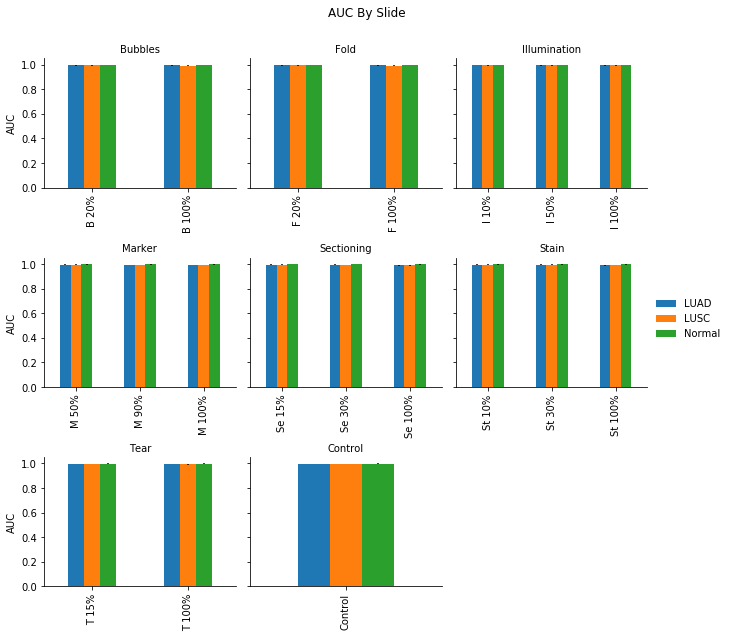

In [15]:
g = sns.FacetGrid(data=phase1_slide_auc,col="group",sharex=False,col_wrap=3)
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("AUC By Slide")

Text(0.5, 0.98, 'AUROC per Slide (By Class)')

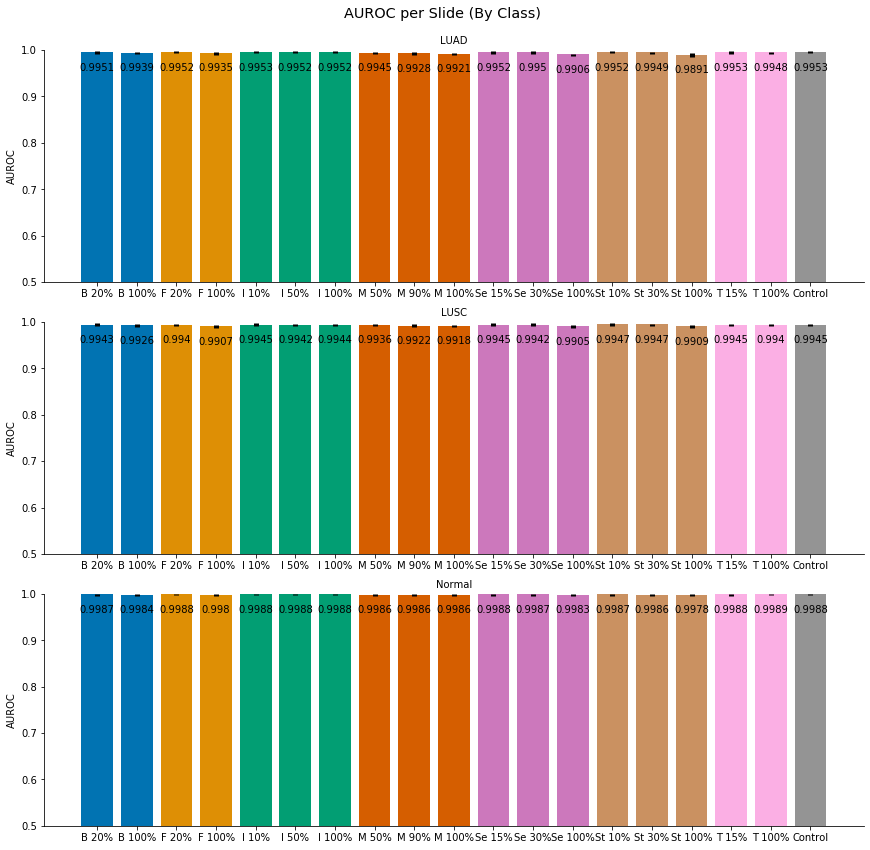

In [16]:
g = sns.FacetGrid(data=phase1_slide_auc,col="class",sharex=False,col_wrap=1,height=4,aspect = 3)
g.map_dataframe(auc_error_bar_plot2,x="study",y="auc",hue="group", lb="ci_lower", ub="ci_upper",
                label_order=phase1_labels.values(),piv="class",palette="colorblind")
# g.map_dataframe(sns.barplot,x="study",y="auc",hue="group",
#                 palette="colorblind",dodge=False)
# g.add_legend()

# g.set(ylim=(.9, 1))
g.set_titles("{col_name}")
g.set_ylabels("AUROC")
plt.subplots_adjust(top=0.93)
plt.suptitle("AUROC per Slide (By Class)",fontsize='x-large')

## Threshold analysis

In [17]:
def threshold_analysis(probs,auc):
# Calculate accuracies depending on threshold
    x = probs[["study","group","class","normal_prob","luad_prob","lusc_prob"]].melt(id_vars=["study","group","class"]).rename(columns=  {"class":"true_class"})
    x["prob_class"] = x["variable"].str[:-5]
    y = auc[["study","class","best_thresh"]]
    y["thresh_class"] = y["class"].str.lower()
    y.drop(columns="class",inplace=True)
    merged = x.merge(y,left_on=["study","prob_class"],right_on=["study","thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    study_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    merged = x.merge(y[y["study"]=="Control"][["thresh_class","best_thresh"]],left_on=["prob_class"],right_on=["thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    ctrl_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    relative_acc = pd.DataFrame({"study_acc":study_thresh_acc,"ctrl_acc":ctrl_thresh_acc}).reindex(phase1_labels.values(),axis=0,level="study").reset_index()
    relative_acc["delta_acc"] = relative_acc["ctrl_acc"] - relative_acc["study_acc"]
    return relative_acc



def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def bar_label(**kwargs):
    sns_t = sns.barplot(**kwargs)
    rects = sns_t.patches
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:0.4f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, (np.sign(height)-1)*5),  # points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

In [18]:
tile_relative_acc = threshold_analysis(phase1_tile_probs,phase1_tile_auc)

/sw/med/lab/ukarvind/modules/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/sw/med/lab/ukarvind/modules/anaconda3/2019.07/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Text(0.5, 0.98, 'Tile Accuracy')

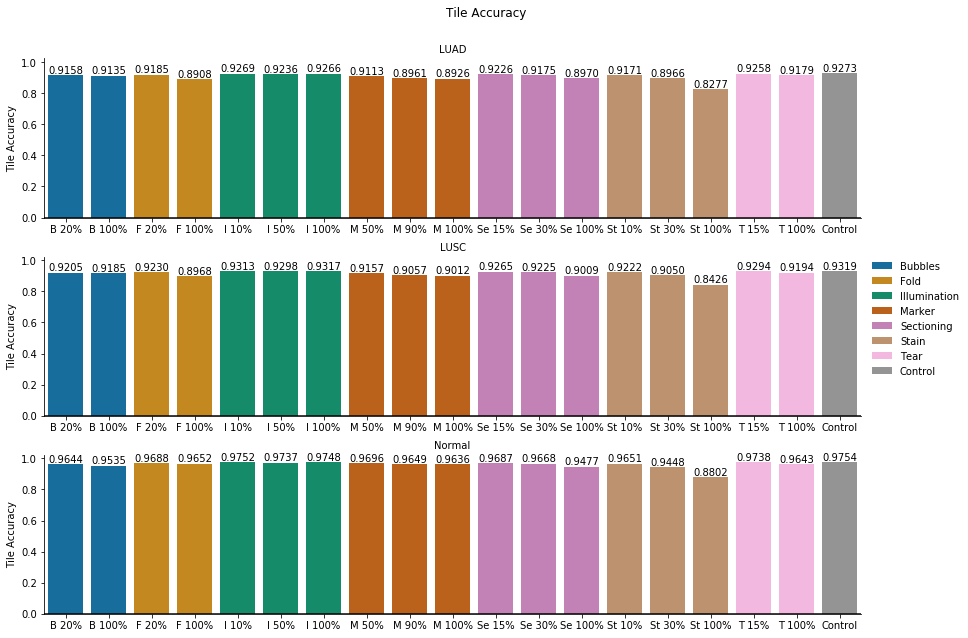

In [19]:
g = sns.FacetGrid(tile_relative_acc, col="true_class",
                sharex=False,col_wrap=1, height=3,aspect = 4) 
g.map_dataframe(bar_label,dodge=False, x="study", y="study_acc",hue="group",palette="colorblind",
                hue_order=["Bubbles","Fold","Illumination","Marker","Sectioning","Stain","Tear","Control"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Tile Accuracy")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Tile Accuracy")

Text(0.5, 0.98, 'Change in Tile Accuracy Due to Threshold Change')

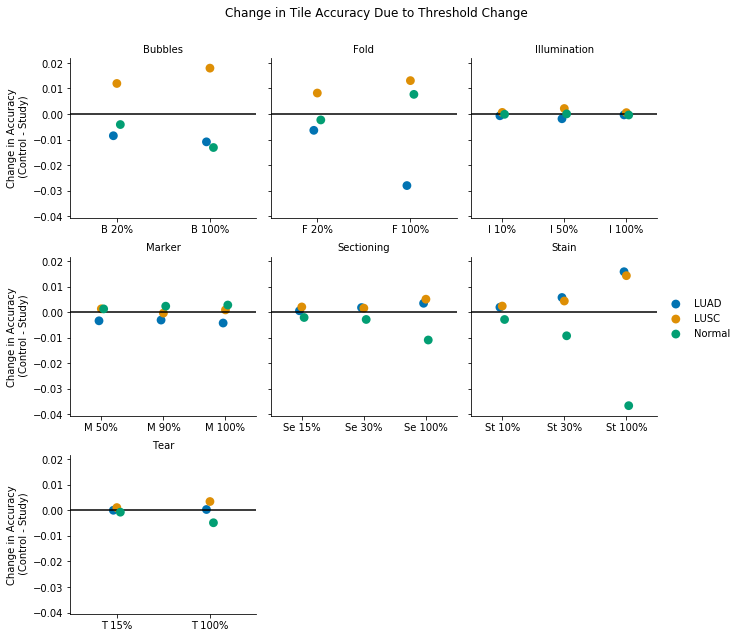

In [20]:
g = sns.FacetGrid(tile_relative_acc[tile_relative_acc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy\n (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Change in Tile Accuracy Due to Threshold Change")


Text(0.5, 0.98, 'Change in Tile Accuracy Due to Threshold Change')

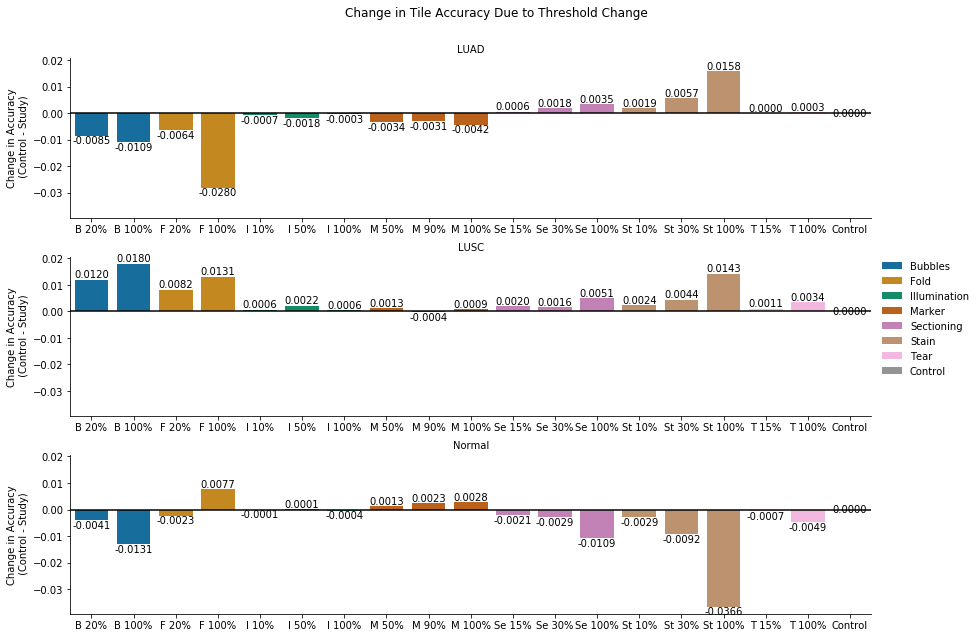

In [21]:
g = sns.FacetGrid(tile_relative_acc, col="true_class",
                sharex=False,col_wrap=1, height=3,aspect = 4) 
g.map_dataframe(bar_label,dodge=False, x="study", y="delta_acc",hue="group",palette="colorblind",
                hue_order=["Bubbles","Fold","Illumination","Marker","Sectioning","Stain","Tear","Control"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy\n (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Change in Tile Accuracy Due to Threshold Change")

/sw/med/lab/ukarvind/modules/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 0.98, 'Change in Slide Accuracy Due to Threshold Change')

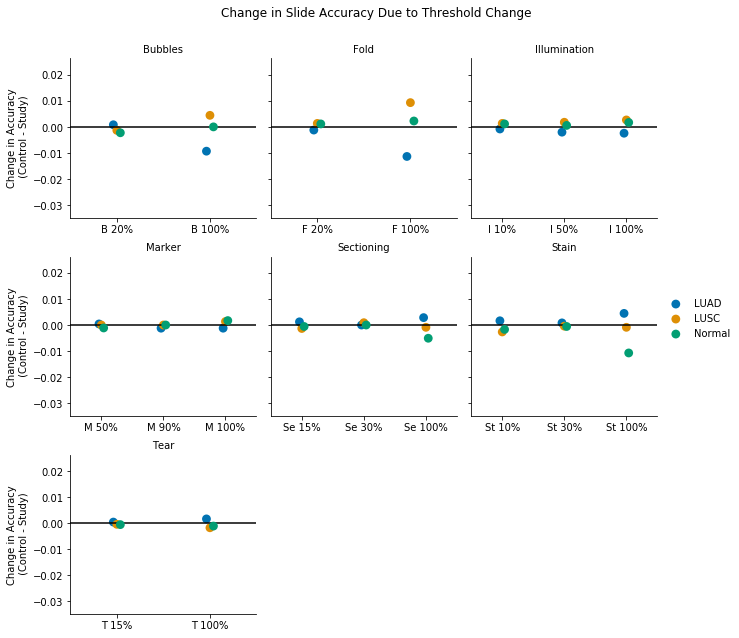

In [22]:
slide_relative_acc = threshold_analysis(phase1_slide_probs,phase1_slide_auc)
g = sns.FacetGrid(slide_relative_acc[slide_relative_acc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy\n (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Change in Slide Accuracy Due to Threshold Change")


Text(0.5, 0.98, 'Slide Accuracy')

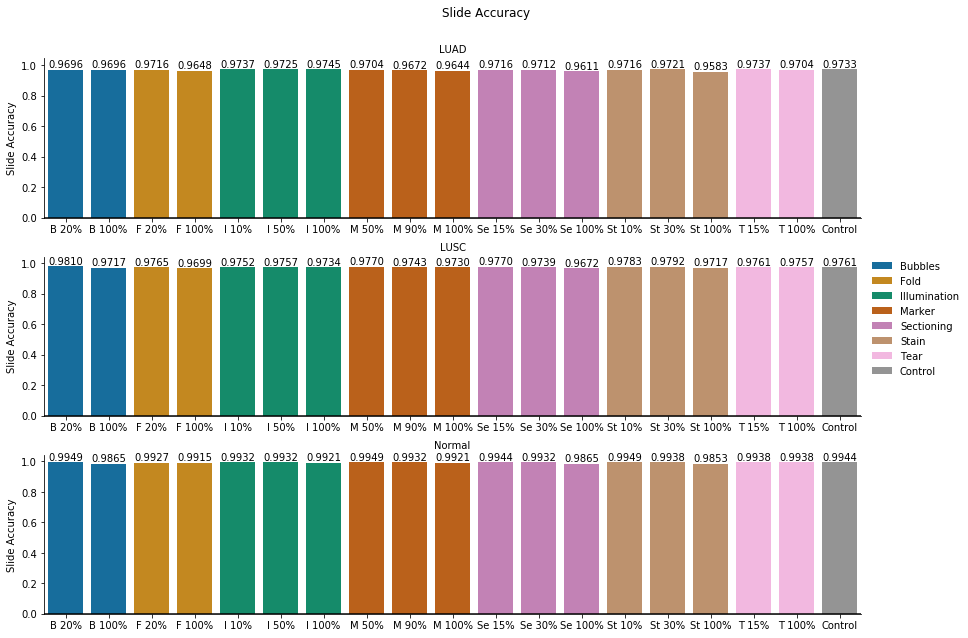

In [23]:
g = sns.FacetGrid(slide_relative_acc, col="true_class",
                sharex=False,col_wrap=1, height=3,aspect = 4) 
g.map_dataframe(bar_label,dodge=False, x="study", y="study_acc",hue="group",palette="colorblind",
                hue_order=["Bubbles","Fold","Illumination","Marker","Sectioning","Stain","Tear","Control"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Slide Accuracy")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Slide Accuracy")

## Modified tile comparisons


In [24]:
mod_tiles = pd.concat({
    label: pd.DataFrame(dp.parse_modified_tile_log(int_dir / study / "log_modified_tiles.txt"),columns=["name","tile"])
    for study,label in phase1_labels.items()
    if study != "all"
},names=["study","prev"],copy=False).reset_index().drop(columns=["prev"]).drop_duplicates()

FileNotFoundError: [Errno 2] No such file or directory: '/data/ncwang/histopath_failure_modes/work/intermediate/exp_bubbles_20/log_modified_tiles.txt'

In [ ]:
mod_tiles.shape

In [ ]:
mod_tile_prob = mod_tiles.merge(phase1_tile_probs,on=["study","name","tile"],how="inner")

In [ ]:
g = sns.FacetGrid(data=mod_tile_prob,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Manipulated Tile True Probabilities (By Class)")

In [ ]:
mod_avg_slide_prob = mod_tile_prob.groupby(["group","study","name","class"]).agg({"corrected_true_prob":"mean"}).reset_index()

In [ ]:
g = sns.FacetGrid(data=mod_avg_slide_prob,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Modified Tile Slide Average True Probabilities (By Class)")

In [ ]:
mod_tile_prob["frac"] = mod_tile_prob["study"].str.extract(r"[\w+] ([\d]+%)",expand=False).str.capitalize()

In [ ]:
mod_tile_prob.groupby(["frac"]).agg({"group":lambda x: [x.unique()]})

In [ ]:
mod_tile_diff = mod_tile_prob.\
    groupby(["frac","name","tile","class"]).\
    agg({
        "study":"count",
        "group":lambda x: "-".join(x),
        "corrected_true_prob":lambda x: [np.diff(x)]
    }).\
    query("study>1").\
    reset_index()
mod_tile_diff["diff_prob"]=[np.abs(y[0][0]) for y in mod_tile_diff["corrected_true_prob"]]

In [ ]:
mod_tile_diff["diff_prob"]=[np.abs(y[0][0]) for y in mod_tile_diff["corrected_true_prob"]]

In [ ]:
g = sns.FacetGrid(data=mod_tile_diff,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="frac",y="diff_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Difference in probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Difference in prediction probability between perturbations of the same tile")